#1. 이해하기

# 1.1 정의

ADK에서 워크플로우 에이전트는 **하위 에이전트(sub-agents)의 실행 흐름을 제어하는 전문화된 에이전트**입니다. 이들은 에이전트가 **어떻게 그리고 언제 실행될지를 관리**하며, **프로세스의 제어 흐름을 정의**하는 역할을 합니다.

## 1.2 특징

*   **사전 정의된 로직 기반 동작**: 워크플로우 에이전트는 LLM(대규모 언어 모델)을 사용하여 동적인 추론 및 의사 결정을 내리는 LLM 에이전트와 달리, 사전에 정의된 로직에 따라 작동합니다. 즉, **오케스트레이션 자체를 위해 LLM에 의존하지 않습니다.**
*   비추론적 역할: **자체적으로 추론하지 않으며**, 태스크를 직접 수행하기보다는 **감독자(director)의 역할**을 수행합니다.
*   결정론적 실행: 이러한 사전 정의된 로직 덕분에 워크플로우 에이전트의 실행 패턴은 결정론적이고 예측 가능합니다. **원하는 순서와 특정 조건 하에 태스크가 수행되도록 보장**합니다.
*   컨텍스트 흐름 제어: **하위 에이전트들 간에 컨텍스트의 흐름을 제어**하며, 특히 `SequentialAgent`의 경우 동일한 `InvocationContext`를 순차적으로 전달하여 상태 공유를 용이하게 합니다.
*   에이전트 간 직접 실행: **사용자의 개입 없이 에이전트 간에 직접 실행** 흐름을 생성할 수 있습니다.

## 1.3 종류

- SequentialAgent
- LoopAgent
- ParallelAgent

## 1.4 SequentialAgent

### 1.4.1 역할 및 특징

1.  순차적 실행: SequentialAgent의 핵심 기능은 지정된 하위 에이전트 목록을 **정해진 순서대로 하나씩 실행**하는 것입니다. 하위 에이전트는 목록에 나열된 순서대로 실행됩니다.
2.  결정론적 동작: 다른 워크플로우 에이전트와 마찬가지로, SequentialAgent는 LLM(대규모 언어 모델)에 기반하여 실행 순서를 결정하는 것이 아니라, **사전에 정의된 로직(즉, 하위 에이전트 목록의 순서)에 따라 작동**합니다. 따라서 주어진 입력과 설정에 대해 실행되는 에이전트의 순서는 항상 동일하며, 예측 가능하고 결정론적입니다. 이는 일관되고 신뢰할 수 있는 실행이 중요한 구조화된 프로세스에 유용합니다.
3.  컨텍스트 공유: SequentialAgent는 실행될 때 하위 에이전트들에게 **동일한 InvocationContext**를 순차적으로 전달합니다. 이를 통해 에이전트들은 **공유된 세션 상태(Shared Session State)**를 통해 쉽게 결과를 주고받을 수 있습니다.
4.  **state를 통한 데이터 전달**: 이전 단계의 하위 에이전트가 자신의 최종 응답이나 결과를 세션 상태에 `output_key`를 사용하여 저장하면, 다음 순서의 하위 에이전트가 해당 상태에서 정보를 읽어 이를 활용할 수 있습니다.

### 1.4.2 사용 시점

*   **명확한 순서 의존성**: 태스크가 명확히 구분되고 순차적인 의존성을 가질 때 사용하기 좋습니다. 즉, 한 에이전트의 출력이 다음 에이전트의 입력이 되어야 하는 '조립 라인' 방식의 워크플로우에 적합합니다.
*   다단계 프로세스 구현: **여러 단계를 거쳐야 하는 복잡한 태스크를 구현**할 때, 각 단계를 별도의 에이전트로 만들고 SequentialAgent로 묶어 실행 순서를 보장합니다.

## 1.5 flow

### 1.5.1 Agent에 따른 state 변환

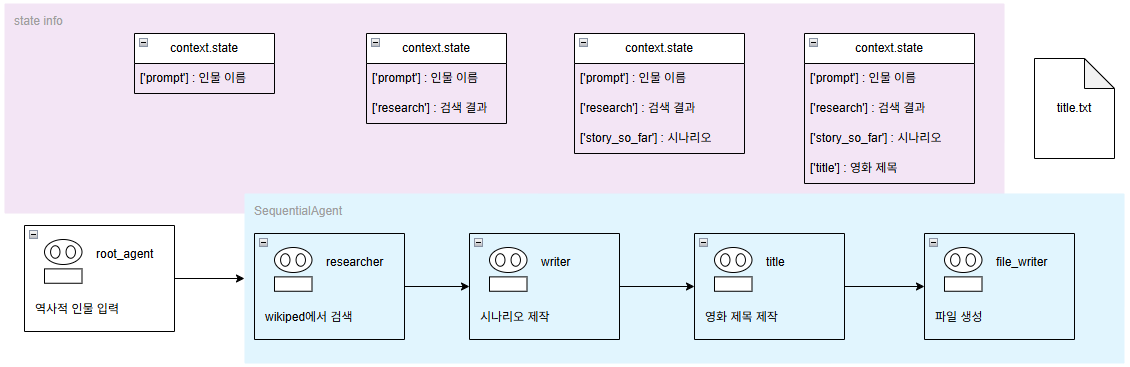

### 1.5.2 전체 흐름

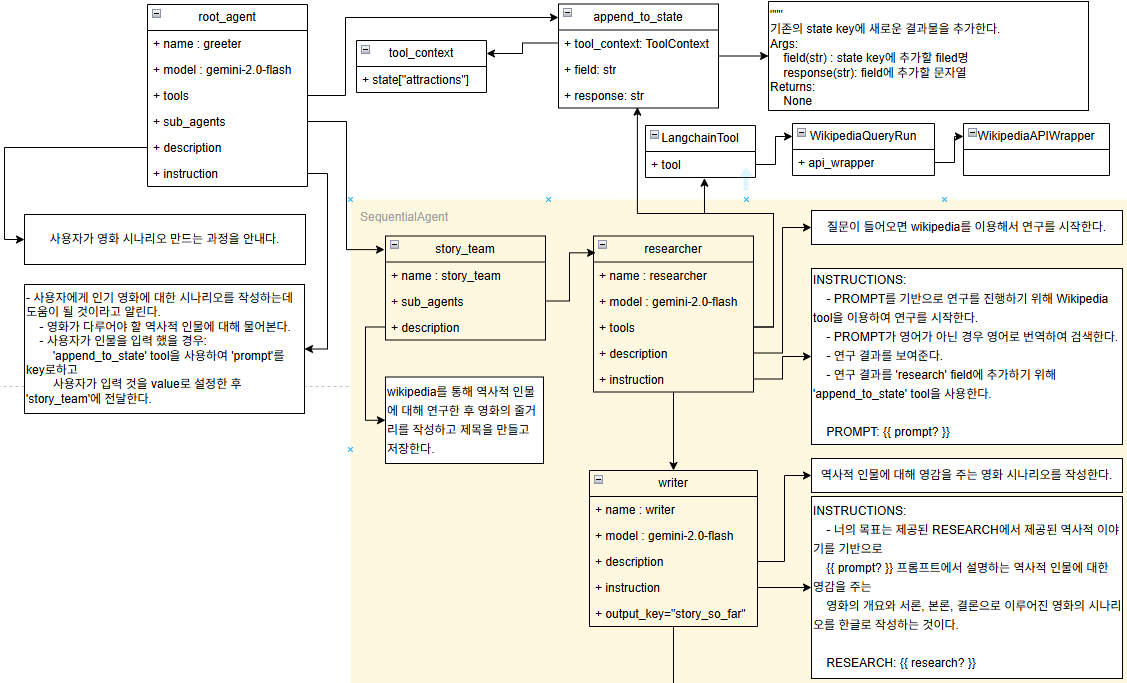

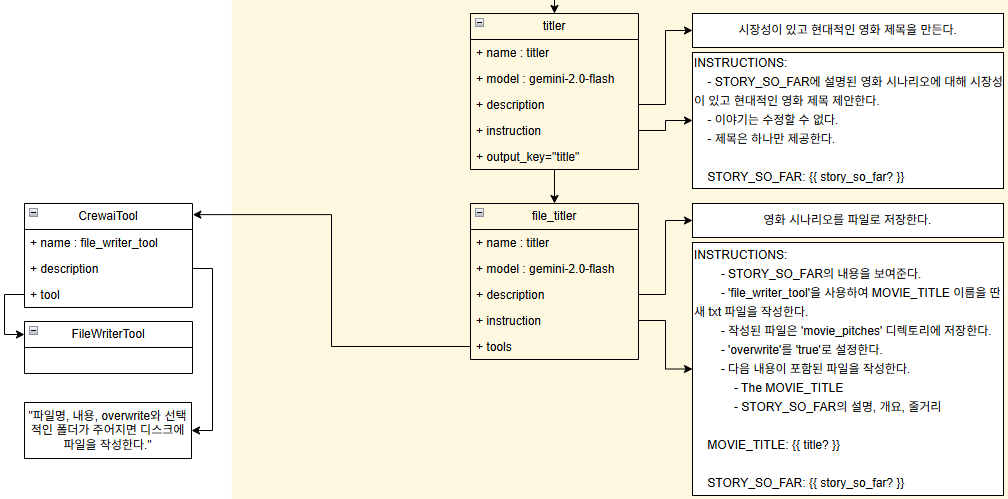

### 1.5.3 실행 결과 및 추후 진행 사항

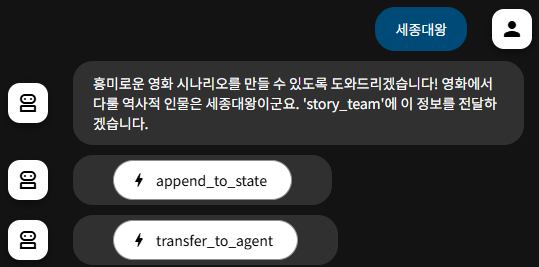

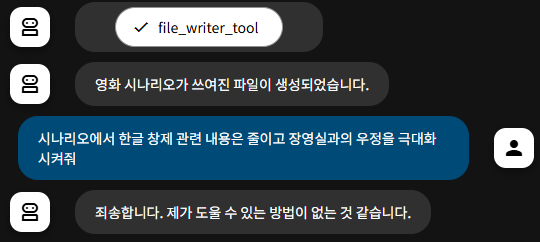

# 2. code



```
pip install google-adk
pip install langchain-community crewai-tools wikipedia
```





```
from google.adk import Agent
from google.adk.agents import SequentialAgent
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.langchain_tool import LangchainTool
from google.adk.tools.crewai_tool import CrewaiTool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from crewai_tools import FileWriterTool

model_name="gemini-2.0-flash"

def append_to_state(
    tool_context: ToolContext,
    field: str,
    response: str
) -> dict[str, str]:
    """
    기존의 state key에 새로운 결과물을 추가한다.
    Args:
        field (str): state에 추가할 key 이름
        response (str): field에 추가할 문자열
    
    Returns:
        dict[str, str]: {"status": "success"}
    """
    existing_state = tool_context.state.get(field, [])
    tool_context.state[field] = existing_state + [response]
    return {"status": "success"}
    
file_writer = Agent(
    name="file_writer",
    model=model_name,
    description="영화 시나리오를 파일로 저장한다.",
    instruction="""
    INSTRUCTIONS:
        - STORY_SO_FAR의 내용을 보여준다.
        - 'file_writer_tool'을 사용하여 MOVIE_TITLE 이름을 딴 새 txt 파일을 작성한다.
        - 작성된 파일은 'movie_pitches' 디렉토리에 저장한다.
        - 'overwrite'를 'true'로 설정한다.
        - 다음 내용이 포함된 파일을 작성한다.
            - The MOVIE_TITLE
            - STORY_SO_FAR의 설명, 개요, 줄거리

    MOVIE_TITLE: {{ title? }}

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    tools = [CrewaiTool(
        name="file_writer_tool",
        description=("파일 이름, 콘텐츠, 디렉터리를 설정한 후 실행하면 디스크에 파일을 만든다."),
        tool=FileWriterTool()
    )]
)

titler = Agent(
    name="titler",
    model=model_name,
    description="시장성이 있고 현대적인 영화 제목을 만든다.",
    instruction="""
    INSTRUCTIONS:
    - STORY_SO_FAR에 설명된 영화 시나리오에 대해 시장성이 있고 현대적인 영화 제목 제안한다.
    - 이야기는 수정할 수 없다.
    - 제목은 하나만 제공한다.

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    output_key="title",
    )

writer = Agent(
    name="writer",
    model=model_name,
    description="역사적 인물에 대해 영감을 주는 영화 시나리오를 작성한다.",
    instruction="""
    INSTRUCTIONS:
    - 너의 목표는 제공된 RESEARCH에서 제공된 역사적 이야기를 기반으로
    {{ prompt? }} 프롬프트에서 설명하는 역사적 인물에 대한 영감을 주는
    영화의 개요와 서론, 본론, 결론으로 이루어진 영화의 시나리오를 한글로 작성하는 것이다.

    RESEARCH: {{ research? }}
    """,
    output_key="story_so_far",
)

researcher = Agent(
    name="researcher",
    model=model_name,
    description="질문이 들어오면 wikipedia를 이용해서 연구를 시작한다.",
    instruction="""
    INSTRUCTIONS:
    - PROMPT를 기반으로 연구를 진행하기 위해 Wikipedia tool을 이용하여 연구를 시작한다.
    - PROMPT가 영어가 아닌 경우 영어로 번역하여 검색한다.
    - 연구 결과를 보여준다.
    - 연구 결과를 'research' field에 추가하기 위해 'append_to_state' tool을 사용한다.

    PROMPT: {{ prompt? }}
    """,
    tools = [
        LangchainTool(
            tool=WikipediaQueryRun(
                api_wrapper=WikipediaAPIWrapper()
            )
        ),
        append_to_state
    ]
)


story_team = SequentialAgent(
    name="story_team",
    description="wikipedia를 통해 역사적 인물에 대해 연구한 후 영화의 줄거리를 작성하고 제목을 만들고 저장한다.",
    sub_agents=[
              researcher,
              writer,
              titler,
              file_writer
            ]
)

root_agent = Agent(
    name="greeter",
    model=model_name,
    description="사용자가 영화 시나리오를 만드는 과정을 안내한다.",
    instruction="""
    - 사용자에게 인기 영화에 대한 시나리오를 작성하는데 도움이 될 것이라고 알린다.
    - 영화가 다루어야 할 역사적 인물에 대해 물어본다.
    - 사용자가 인물을 입력 했을 경우:
        'append_to_state' tool을 사용하여 'prompt'를 key로하고
        사용자가 입력 것을 value로 설정한 후 'story_team'에 전달한다.
    """,
    tools=[append_to_state],
    sub_agents=[story_team]
)
```

